# Assignment 2 Part 2: Building a Differentiable Texture

In the part 2 of this assignment, a very important (and fun) task we're going to do is to build a differentiable volume renderer that can recover volumetric textures from a set of images. But before we get to that, we need to understand why and how to build differentiable textures in slang.

We'll walk you through this process in this notebook by building a simple 2D differentiable texture and a differentiable sampler first.

## Why Build Our Own Texture Implementation?

Most graphics libraries and shading languages come with built-in support for textures. Slang is no exception. In Slang, you can define textures using the `Texture2D` and `Texture3D` types. To sample from these textures, you can use the `SamplerState` type along with the `sample` function.

So why are we building our own texture implementation? Well, one reason is we want to teach you how texture sampling with bilinear/trilinear interpolation works under the hood. But the main reason is that the `Texture3D` and `SamplerState` are implemented in **hardware** on your GPU! This means that they are not differentiable. By building our own texture and sampler in software, we can build a differentiable texture infrastructure that we can use in our differentiable volume renderer later on.

In this notebook, we'll implement a 2D differentiable texture along with a differentiable bilinear sampler to give you a taste of how this works.

### I Thought Slang is a Differentiable Shading Language?

> Some of you might be wondering: isn't Slang a differentiable shading language? Isn't everything in Slang differentiable by default?
>
> What Slang's automatic differentiation compiler guarantees is that if you have a function `foo` that takes some input `T x` where `T` **inherits `IDifferentiable` or `IDifferentiablePtrType` interface**, then Slang can automatically generate a backward function `foo_bwd` for you that computes the gradients of `x` given the gradient of the output of `foo`. If the input type `T` does not inherit from these interfaces, then Slang cannot automatically generate the backward function for you.
>
> In our case, the built-in `Texture2D` type does not inherit from `IDifferentiable` or `IDifferentiablePtrType`(because it is a hardware resource type), so Slang cannot automatically generate the backward function for texture sampling for us.
>
> Up until a few weeks ago, the only way to build differentiable textures in Slang was to implement your own texture type that inherits from `IDifferentiablePtrType` and implement the sampling and backward functions yourself (which is what we're going to do in this notebook).
>
> Recently, SlangPy has introduced their official differentiable tensor support: https://slangpy.shader-slang.org/en/latest/src/tensors/python.html#
>
> If you want to learn more about how automatic differentiation works in Slang, check out the [Slang documentation on Automatic Differentiation](https://docs.shader-slang.org/en/latest/external/slang/docs/user-guide/07-autodiff.html#differentiable-ptr-types).

### The Full Picture

To get more specific, here's the full picture of what we're going to do in this notebook:

1. Create a **low-resolution** 2D differentiable texture that we can optimize.
2. Implement a differentiable bilinear sampler that can sample from this texture given UV coordinates.
3. Upsample the low-resolution sampled texture to the target image resolution using bilinear interpolation.
4. Optimize the low-resolution texture such that when we sample and upsample it, it matches the target image as closely as possible.

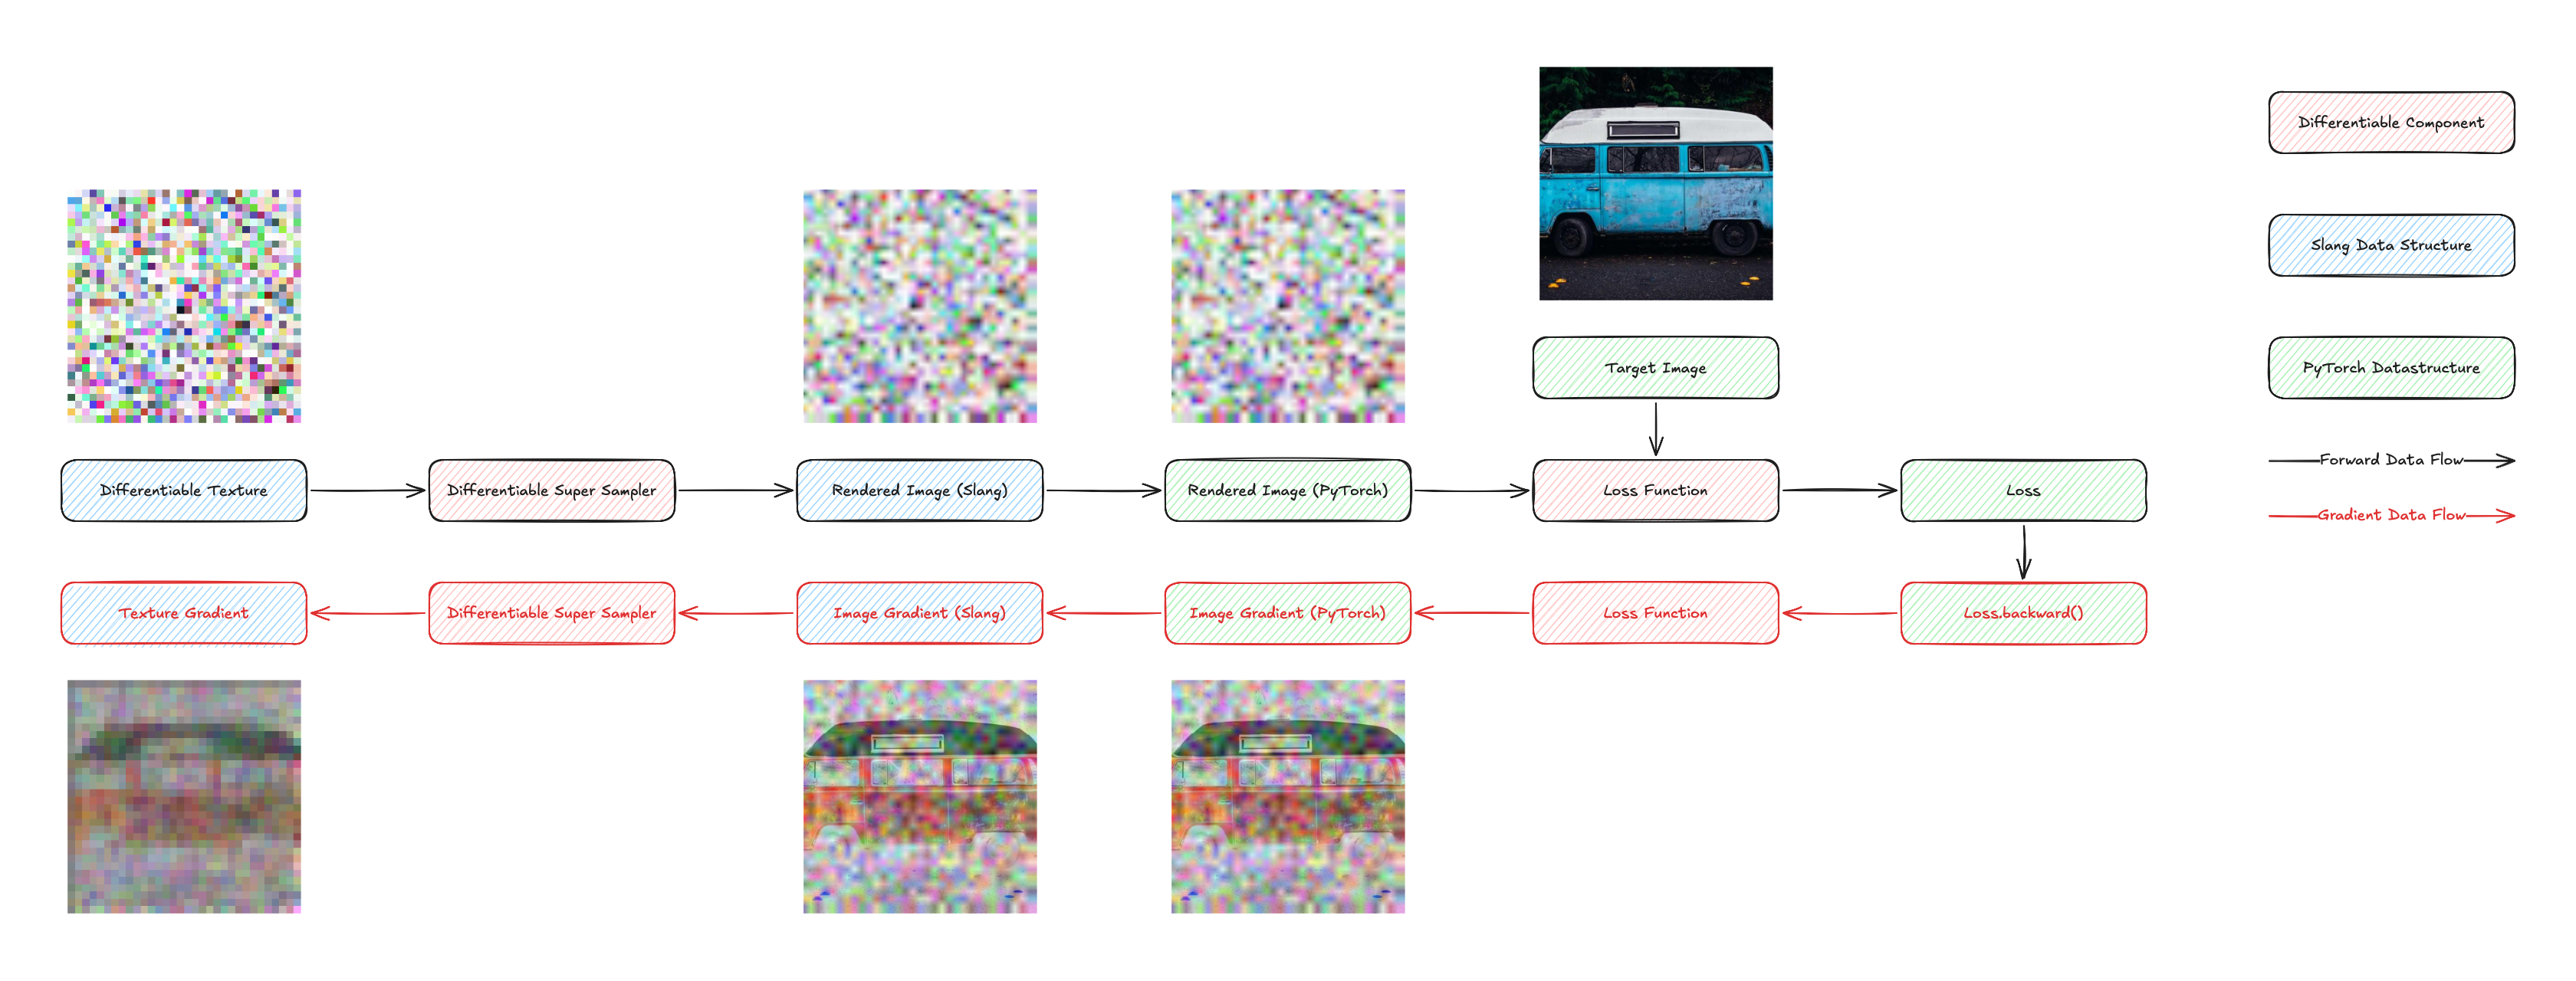

In [20]:
import slangpy as spy
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import pathlib
from tqdm.notebook import tqdm

import torch
import torch.nn as nn

from cs248a_renderer import setup_device, RendererModules

# Set random seed for reproducibility
np.random.seed(42)

In [21]:
# Device setup
diff_texture_shader_path = pathlib.Path.cwd() / "shaders"
device = setup_device([diff_texture_shader_path])
renderer_modules = RendererModules(device)
upsampler_module = spy.Module.load_from_file(
    device=device,
    path="upsampler.slang",
    link=[renderer_modules.texture_module]
)

[INFO] (rhi) layer: CreateDevice: Debug layer is enabled.
[WARN] No supported shader model found, pretending to support sm_6_0.


### Inspect Our Target Image

Download the `target_image.png` from the assignment 2 resources folder: https://drive.google.com/drive/folders/1biYrBrNYx1sBlkcuyx3RARH9g9PaVHgL?usp=share_link and save it in the `resources` directory.

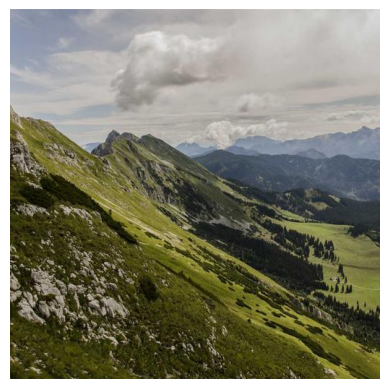

In [22]:
# Load and display the target image
img = Image.open("../../../resources/target_image.png").convert("RGBA")
image_size = img.size
img = np.array(img).astype(np.float32) / 255.0
plt.imshow(img)
plt.axis("off")
plt.show()


### Create the Learnable Texture

Now, let's create the low-resolution texture that we will optimize. We'll initialize it with uniform random values from [0, 1].

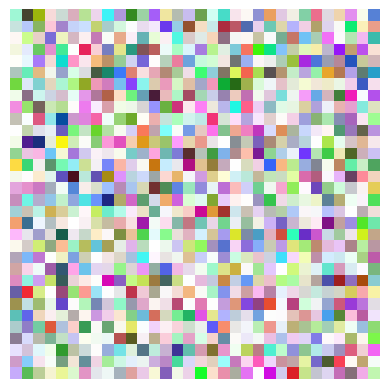

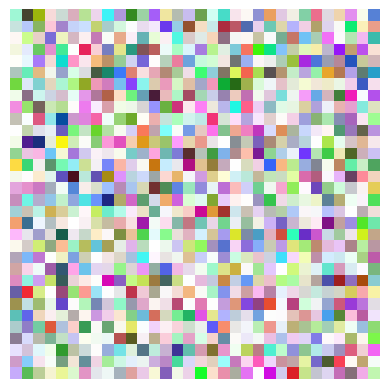

In [23]:
# Generate a noise texture.
texture_size = 32
sample_data = np.random.rand(texture_size, texture_size, 4).astype(np.float32)
sample_texture = spy.NDBuffer(
    device=device,
    dtype=upsampler_module.float4,
    shape=(texture_size * texture_size,)
)
sample_texture.copy_from_numpy(sample_data.reshape((-1, 4)))
# Display the sample texture
sample_texture_data = sample_texture.to_numpy().reshape((texture_size, texture_size, 4))
plt.imshow(sample_texture_data)
plt.axis("off")
plt.show()

### Implement the Bilinear Sampler for `DiffTexture2D`

Now, read `DiffTexture2D`, `DiffTexture2D_Differential`, `samplePoint`, and `samplePoint_bwd` in `src/cs248a_renderer/slang_shaders/texture/diff_texture.slang` to learn about how we defined the 2D differentiable texture data structure and the differentiable point sampler. When reading the code, pay special attention to the following:

1. The `DiffTexture2D` stores its data in a `StructuredBuffer<vector<T, N>>` type, where its differential stores data in a `RWStructuredBuffer<Atomic<T>[N]>` type. For `DiffTexture2D`, we're only reading from it during rendering. But for its differential, we need to write to it during the gradient accumulation in the backward pass, so we use a read-write buffer. Most importantly, **multiple GPU threads may write to the same location in the differential buffer at the same time**, so we need to use atomic data types to avoid race conditions.
2. In `samplePoint`, we simply read from the texture buffer and return the value. But in `samplePoint_bwd`, we are using `Atomic<T>.add` instead of `+=` to accumulate gradients. This is for the same reason as above -- multiple threads may write to the same location, so we need to use atomic operations to avoid race conditions.
3. The type inside the differential buffer is `Atomic<T>[N]` instead of `Atomic<vector<T, N>>`. This is because Slang does not support atomic operations on vector types directly. So we need to store each channel separately as an array of atomic scalars. In the backward function, we then accumulate gradients for each channel separately. The `[ForceUnroll]` attribute is used to ensure that the loop is unrolled at compile time for performance reasons.

Notice that the `samplePoint` is decorated with the `[BackwardDerivative(samplePoint_bwd)]` attribute. This tells Slang to use `samplePoint_bwd` as the backward function when computing gradients for `samplePoint`. So every time we call `bwd_diff(samplePoint)(diffTexPair, uv, dOut)`, Slang will automatically call `samplePoint_bwd(diffTexPair, uv, dOut)` to compute the gradients and accumulate them into the differential buffer.

Implement `sampleBilinear_bwd` in `src/cs248a_renderer/slang_shaders/texture/diff_texture.slang` to complete the backward function for `sampleBilinear`.

### Implement the Upsampling Renderer

Implement `sampling_fwd` in `notebooks/assignment2-part2/volume-recovery/shaders/upsampler.slang` to upsample the low-resolution sampled texture to the target image resolution using `sampleBilinear`.

If you implement it correctly, you should be able to produce the following result:

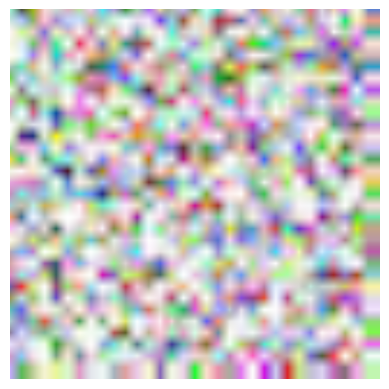

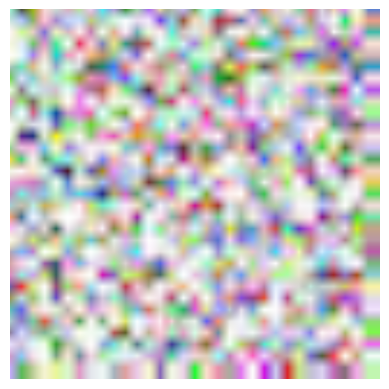

In [24]:
render_texture = device.create_texture(
    type=spy.TextureType.texture_2d,
    format=spy.Format.rgba32_float,
    width=image_size[0],
    height=image_size[1],
    usage=spy.TextureUsage.unordered_access | spy.TextureUsage.shader_resource
)
upsampler_module.sampling_fwd(
    tid=spy.grid((image_size[0], image_size[1])),
    canvasSize=[image_size[0], image_size[1]],
    sampleTex=sample_texture,
    texSize=[texture_size, texture_size],
    _result=render_texture
)
# Display the rendered texture
render_texture_data = render_texture.to_numpy()
plt.imshow(render_texture_data)
plt.axis("off")
plt.show()

### Sending the Rendered Image to PyTorch for Gradient Computation

After we rendered the upsampled image in Slang, we need to send it to PyTorch to compute the loss and backpropagate the gradients.

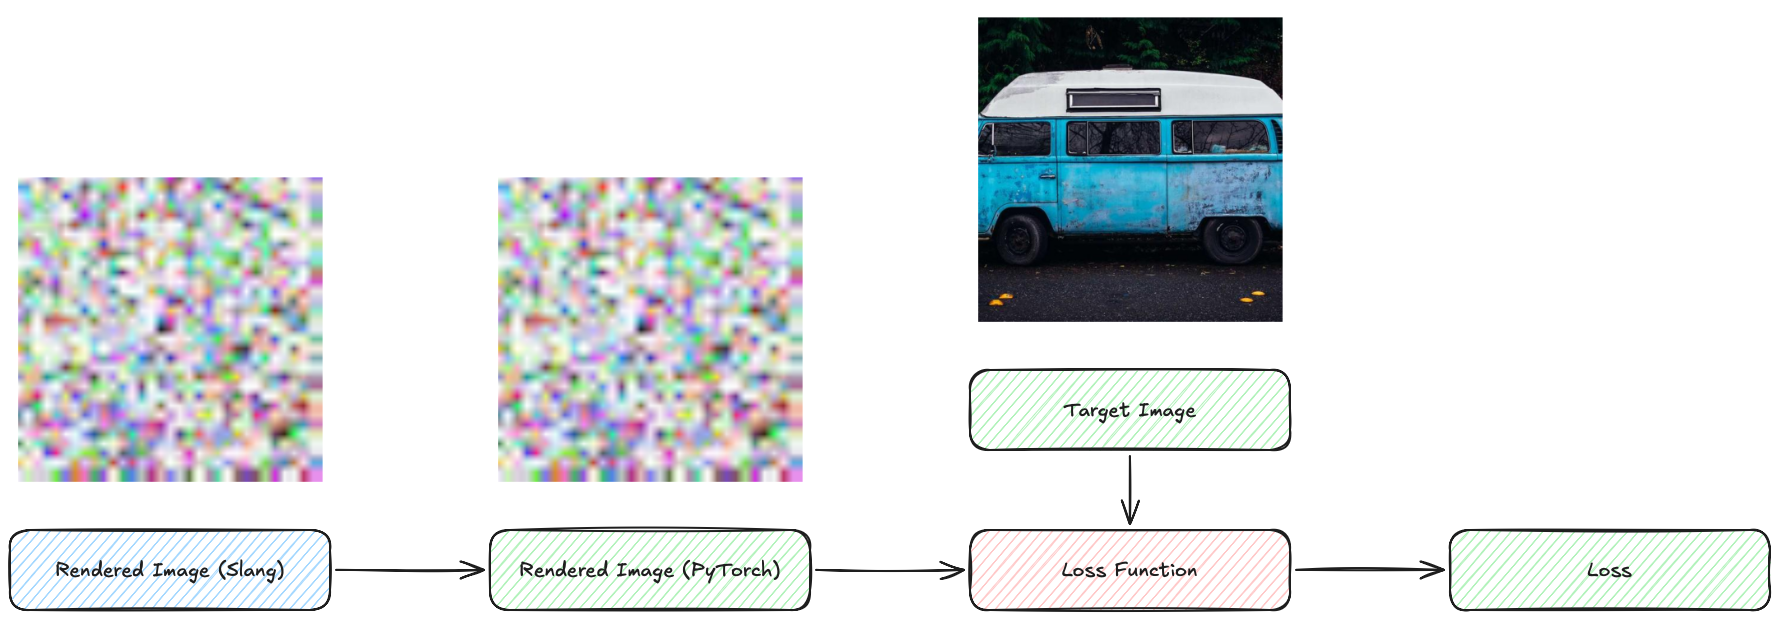

Why don't we just compute the loss and backpropagate the gradients in Slang directly? Well, it might be easy to compute something as simple as an L2 loss in Slang, but imagine if we want to perform some more complex deep learning operations on the rendered image, implementing all those operations in Slang would be a huge pain.

Instead, we can connect the rendered image from Slang to PyTorch tensors and expand the possibilities of what we can do with the rendered image. For example, you can render a scene with the differentiable renderer in Slang, send the rendered image to PyTorch, and then process the image with a pre-trained deep neural network in PyTorch to compute some perceptual loss. This way, the entire pipeline remains differentiable, and you can backpropagate gradients all the way from the perceptual loss to the scene parameters in Slang!

In [25]:
# Send the rendered texture to PyTorch (set requires_grad=True to enable gradient computation)
res_tensor = torch.tensor(render_texture_data, requires_grad=True)
# Compute the L2 loss between the rendered image and the target image
loss_fn = nn.MSELoss()
loss = loss_fn(res_tensor, torch.tensor(np.array(img)).float())
loss

tensor(0.1512, grad_fn=<MseLossBackward0>)

### Backpropagate the Gradients in PyTorch

In PyTorch, when you call the `backward()` function on a loss tensor, PyTorch will automatically compute the gradients of all tensors in the computation graph that have `requires_grad=True` and accumulate the gradients into their `.grad` attributes. This computation is done using backpropagation we learned in class.

In the following code cell, we call the `backward()` function on the loss tensor to compute the gradients of the loss with respect to the **high-resolution rendered image** stored in `res_tensor`.

This process is illustrated in the red arrow in the following diagram:

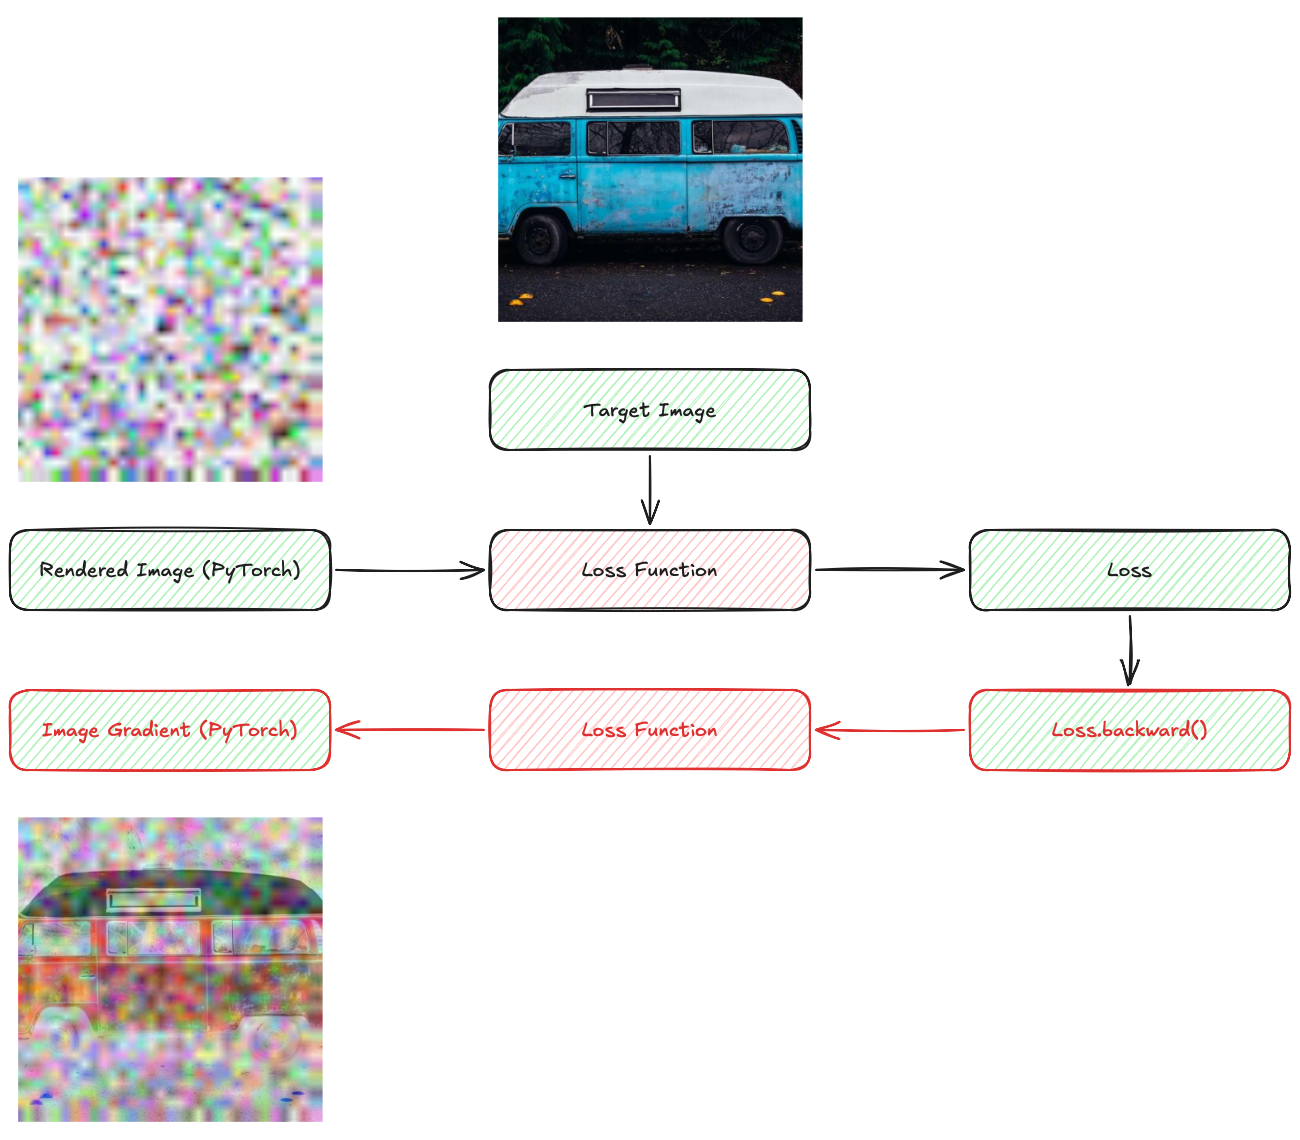

If you implemented everything correctly, you should see the visualization of the gradients of the loss with respect to the high-resolution rendered image below:

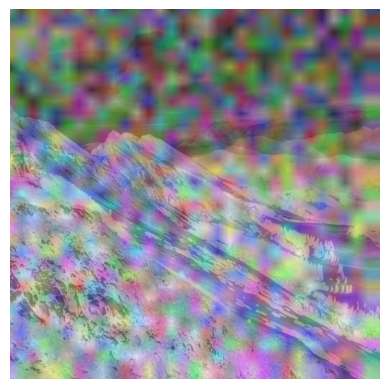

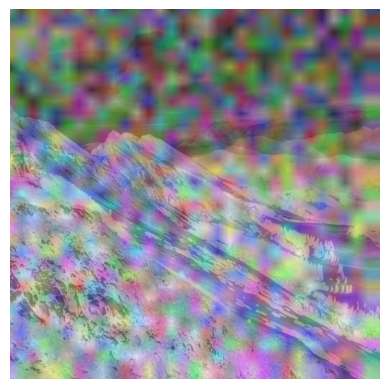

In [26]:
loss.backward()
d_res = res_tensor.grad
d_res_vis = (d_res - d_res.min()) / (d_res.max() - d_res.min())
d_res_vis = d_res_vis[..., :3]
plt.imshow(d_res_vis.detach().numpy())
plt.axis("off")
plt.show()

### Sending the Gradients Back to Slang

Remember that we sent the high-resolution rendered image from Slang to PyTorch earlier. Now that we have computed the gradients of the loss with respect to the high-resolution rendered image in PyTorch, we need to send these gradients back to Slang so that we can continue the backpropagation process in Slang.

Implement `sampling_bwd` in `notebooks/assignment2-part2/volume-recovery/shaders/upsampler.slang` to call the backward function of `sampleBilinear` to propagate the gradients from the high-resolution image back to the low-resolution sampled texture.

In your `sampling_bwd` compute shader kernel, you should assemble a `DifferentialPtrPair` for the low-resolution sampled texture and call `bwd_diff(sampleBilinear)(diffTexPair, uv, dOut)` to propagate the gradients.

> If you see a lot of compiler warnings about unused variables, you can safely ignore them. This is a small issue with the Slang compiler when generating code for atomic operations.

In [27]:
# Store the gradient in a texture
grad_texture = device.create_texture(
    type=spy.TextureType.texture_2d,
    format=spy.Format.rgba32_float,
    width=image_size[0],
    height=image_size[1],
    usage=spy.TextureUsage.shader_resource
)
grad_texture.copy_from_numpy(d_res.detach().numpy())
# Create a texture buffer to store the gradient w.r.t. the sample texture
d_sample_texture = spy.NDBuffer(
    device=device,
    dtype=upsampler_module.find_struct("Atomic<float>[4]"),
    shape=(texture_size * texture_size,)
)
# Run the backward super sampler
upsampler_module.sampling_bwd(
    tid=spy.grid((image_size[0], image_size[1])),
    canvasSize=[image_size[0], image_size[1]],
    sampleTex=sample_texture,
    sampleTexGrad=d_sample_texture,
    texSize=[texture_size, texture_size],
    dOut=grad_texture
)

[WARN] (rhi) slang: metal 32023.850: /Users/stephone/Documents/school/cs248/asst2/src/cs248a_renderer/slang_shaders/./texture/diff_texture.slang(158): warning :  unused variable '_S28' [-Wunused-variable]
    float _S28 = atomic_fetch_add_explicit(&(*(diffTexPair_differential_dTex_0+idx00_0))[0U], _S24 * dOut_1[0U], memory_order_relaxed);
          ^
metal 32023.850: /Users/stephone/Documents/school/cs248/asst2/src/cs248a_renderer/slang_shaders/./texture/diff_texture.slang(159): warning :  unused variable '_S29' [-Wunused-variable]
    float _S29 = atomic_fetch_add_explicit(&(*(diffTexPair_differential_dTex_0+idx10_0))[0U], _S25 * dOut_1[0U], memory_order_relaxed);
          ^
metal 32023.850: /Users/stephone/Documents/school/cs248/asst2/src/cs248a_renderer/slang_shaders/./texture/diff_texture.slang(160): warning :  unused variable '_S30' [-Wunused-variable]
    float _S30 = atomic_fetch_add_explicit(&(*(diffTexPair_differential_dTex_0+idx01_0))[0U], _S26 * dOut_1[0U], memory_order_rel

If you implemented your backward compute shader correctly, you should be able to see the visualization of the gradients of the loss with respect to the low-resolution texture below:

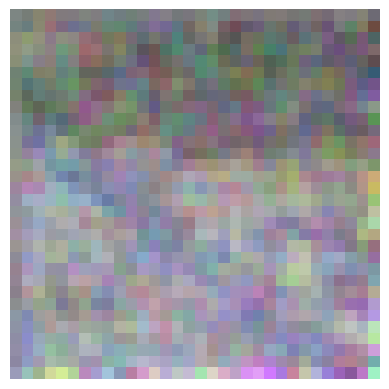

Can you reason about why the gradients look like this?

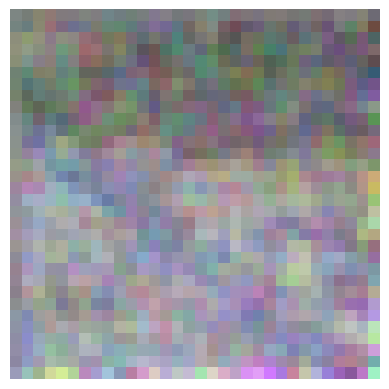

In [28]:
d_tex = d_sample_texture.to_numpy().reshape((texture_size, texture_size, 4))
d_tex_vis = (d_tex - d_tex.min()) / (d_tex.max() - d_tex.min())
d_tex_vis = d_tex_vis[..., :3]
plt.imshow(d_tex_vis)
plt.axis("off")
plt.show()

### Putting It All Together

Now that we have implemented both the forward and backward passes of the entire pipeline, we can put everything together to optimize the low-resolution texture.

In the following code cell, implement the SGD optimization loop to optimize the low-resolution texture such that when we sample and upsample it, it matches the target image as closely as possible.

In each epoch of the optimization loop, you need to do the following:

1. Forward pass
   1. Upsample the low-resolution texture using the upsampler differentiable renderer.
   2. Send the rendered high-resolution image to PyTorch.
   3. Compute the loss between the rendered image and the target image.
2. Backward pass
   1. Call `loss.backward()` in PyTorch to compute the gradients of the loss with respect to the high-resolution rendered image.
   2. Send the gradients of the high-resolution rendered image back to Slang.
   3. Call the backward function of the upsampler to propagate the gradients back to the low-resolution texture.
3. Update the low-resolution texture using SGD

In [36]:
# SGD hyperparameters (feel free to tune these)
learning_rate = 250
epochs = 120

# Store snapshots for animation
SNAPSHOT_INTERVAL = 2
snapshots = []
loss_values = []

# Random initial state
sample_data = np.random.rand(texture_size, texture_size, 4).astype(np.float32)
snapshots.append(sample_data.copy())


sample_texture = spy.NDBuffer(
    device=device,
    dtype=upsampler_module.float4,
    shape=(texture_size * texture_size,)
)
sample_texture.copy_from_numpy(sample_data.reshape((-1, 4)))

# Create a texture buffer to store the gradient w.r.t. the sample texture
d_sample_texture = spy.NDBuffer(
    device=device,
    dtype=upsampler_module.find_struct("Atomic<float>[4]"),
    shape=(texture_size * texture_size,)
)

for epoch in tqdm(range(epochs)):
    #updample the low-res texture using upsampler_module
    upsampler_module.sampling_fwd(
        tid=spy.grid((image_size[0], image_size[1])),
        canvasSize=[image_size[0], image_size[1]],
        sampleTex=sample_texture,
        texSize=[texture_size, texture_size],
        _result=render_texture
    )

    # send the rendered image to pytorch
    res_tensor = torch.tensor(render_texture.to_numpy(), requires_grad=True)

    #compute the loss
    loss = loss_fn(res_tensor, torch.tensor(np.array(img)).float())

    # backpropagate the loss
    loss.backward()

    #send the gradients to slang
    d_res = res_tensor.grad
    grad_texture.copy_from_numpy(d_res.detach().numpy())
    
    # Run the backward super sampler
    upsampler_module.sampling_bwd(
        tid=spy.grid((image_size[0], image_size[1])),
        canvasSize=[image_size[0], image_size[1]],
        sampleTex=sample_texture,
        sampleTexGrad=d_sample_texture,
        texSize=[texture_size, texture_size],
        dOut=grad_texture
    )


    sample_data = sample_texture.to_numpy().reshape((texture_size, texture_size, 4)) - learning_rate * d_sample_texture.to_numpy().reshape((texture_size, texture_size, 4))
    sample_texture.copy_from_numpy(sample_data.reshape((-1, 4)))
    
    


    
    # Save snapshot for every epoch
    if (epoch + 1) % SNAPSHOT_INTERVAL == 0:
        snapshots.append(sample_data.copy())
        loss_values.append(loss.item())

# Final result
upsampler_module.sampling_fwd(
    tid=spy.grid((image_size[0], image_size[1])),
    canvasSize=[image_size[0], image_size[1]],
    sampleTex=sample_texture,
    texSize=[texture_size, texture_size],
    _result=render_texture
)
render_texture_data = render_texture.to_numpy()
plt.imshow(np.clip(render_texture_data, 0, 1))
plt.axis("off")
plt.show()

  0%|          | 0/120 [00:00<?, ?it/s]

RuntimeError: numpy array has wrong number of dimensions (expected 3)
/Users/runner/work/slangpy/slangpy/src/slangpy_ext/device/resource.cpp:317 in function texture_build_subresource_data_for_upload

Finally, let's visualize the optimization process by creating an animation of the learned texture and rendered image over epochs. Run the following cell and play the saved video `texture_recovery_animation.mp4`.

In [11]:
# Create animation
import matplotlib
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set animation.embed_limit to a higher value if the animation is too large
matplotlib.rcParams['animation.embed_limit'] = 2**30  # 1 GB

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# Render all snapshots
print("Rendering snapshots...")
rendered_snapshots = []
for i, snapshot in enumerate(snapshots):
    if i % 20 == 0:
        print(f"Rendered {i}/{len(snapshots)} snapshots")
    temp_texture = spy.NDBuffer(
        device=device,
        dtype=upsampler_module.float4,
        shape=(texture_size * texture_size,)
    )
    temp_texture.copy_from_numpy(snapshot.reshape((-1, 4)))
    
    upsampler_module.sampling_fwd(
        tid=spy.grid((image_size[0], image_size[1])),
        canvasSize=[image_size[0], image_size[1]],
        sampleTex=temp_texture,
        texSize=[texture_size, texture_size],
        _result=render_texture
    )
    rendered_snapshots.append(render_texture.to_numpy())
print(f"Rendered {len(snapshots)}/{len(snapshots)} snapshots")

# Animation function
def animate(frame):
    epoch = frame * SNAPSHOT_INTERVAL  # Because we saved every SNAPSHOT_INTERVAL epochs
    ax1.clear()
    ax2.clear()
    ax3.clear()
    
    # Show the low-res texture
    ax1.imshow(np.clip(snapshots[frame], 0, 1))
    ax1.set_title(f"Texture at Epoch {epoch}")
    ax1.axis("off")
    
    # Show the rendered result
    ax2.imshow(np.clip(rendered_snapshots[frame], 0, 1))
    ax2.set_title(f"Rendered Result at Epoch {epoch}")
    ax2.axis("off")
    
    # Show loss curve up to current epoch
    if frame > 0:
        ax3.plot(range(len(loss_values[:frame])), loss_values[:frame])
    ax3.set_xlim(0, len(loss_values))
    ax3.set_ylim(min(loss_values) * 0.9, max(loss_values) * 1.1)
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Loss")
    ax3.set_title("Loss Convergence")
    ax3.grid(True, alpha=0.3)
    # Make ax3 plot area square
    ax3.set_box_aspect(1)
    
    return ax1, ax2, ax3

# 10 FPS animation
anim = FuncAnimation(fig, animate, frames=len(snapshots), interval=1000 / 10, blit=False)
plt.tight_layout()
plt.close()

# Save the animation as an mp4 file
anim.save("texture_recovery_animation.mp4", writer="ffmpeg", fps=30)

Rendering snapshots...
Rendered 0/61 snapshots
Rendered 20/61 snapshots
Rendered 40/61 snapshots
Rendered 60/61 snapshots
Rendered 61/61 snapshots
